# Step 1 - Frame Dividing Part

#### Install Opencv for Frame Extraction

In [1]:
pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


#### Importing Libraries CV2 and OS

In [2]:
import cv2
import os

#### Function to Extract Frames

In [3]:
from automatic_pipeline.extract_frames import extract_frames

#### Crop black margins

In [4]:
from automatic_pipeline.crop_black_margins import crop_black_margins

# Step 2 - Extracting Key points

#### Install mediapipe

In [5]:
pip install mediapipe


#### Detect Keypoints - Annotate the Frames

In [6]:
from automatic_pipeline.annotate_frames import detect_keypoints

#### Extract 2D Key Point Data into Json

In [7]:
from automatic_pipeline.extract_2d_keypoint import extract_2d_keypoints

#### Normalize the data

- According to hip dne when extracting 2D keypoints

# Step 3 - Feature Extraction using Media Pipe

#### Get Angles from Keypoints

In [8]:
from automatic_pipeline.extract_joint_angles import extract_joint_angles

#### Extract velocities

In [9]:
from automatic_pipeline.extract_velocities import extract_velocity_side_view

# Step 4 - Creating Dataset

#### Install Pandas

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Creating Dataset for GRU regression - This will be used in Automatic pipeline

# Automatic Pipeline function

In [11]:
import os
import cv2
import json
import csv
import shutil
from datetime import datetime

# ======================= #
# ==== CONFIGURATION ==== #
# ======================= #

# Hardcoded output paths for consistency
FRAMES_ROOT = "Output/frames"
KEYPOINTS_ROOT = "Output/keypoints"
ANNOTATIONS_ROOT = "Output/annotations"
LOG_FILE = "Output/processing_log.txt"
CENTRAL_INDEX_FILE = "Output/central_index.csv"


# Features to extract from the video

ANGLES_ROOT = "Output/angles"
VELOCITIES_ROOT = "Output/velocities"
PHASE_ROOT = "Output/phase_data"

# Create all required output folders at startup
for path in [FRAMES_ROOT, KEYPOINTS_ROOT, ANNOTATIONS_ROOT, ANGLES_ROOT,VELOCITIES_ROOT,PHASE_ROOT, os.path.dirname(LOG_FILE)]:
    os.makedirs(path, exist_ok=True)

# =============================== #
# ==== UTILITY HELPER FUNCS ==== #
# =============================== #

# This function retrieves all video files from the specified root folder and its subdirectories.
## It supports multiple file extensions (e.g., .mp4, .mov) and returns a list of full paths.
def get_all_video_paths(root_folder, extensions=(".mp4", ".MOV")):
    video_paths = []
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith(extensions):
                video_paths.append(os.path.join(dirpath, file))
    return video_paths


# This function generates a relative path for a video file based on the root input folder.
def get_relative_path(video_path, root_folder):
    return os.path.relpath(video_path, root_folder)

# This function builds output paths for frames, keypoints, annotations, and metadata based on the video path.
# It uses the relative path to create a consistent structure under the defined output folders.
def build_output_paths(video_path, root_input_folder):
    relative_path = get_relative_path(video_path, root_input_folder)
    base = os.path.splitext(relative_path)[0]
    return {
        "frames": os.path.join(FRAMES_ROOT, base),
        "keypoints": os.path.join(KEYPOINTS_ROOT, base),
        "annotations": os.path.join(ANNOTATIONS_ROOT, base),
        "metadata": os.path.join(KEYPOINTS_ROOT, base, "metadata.json"),
        "angles": os.path.join(ANGLES_ROOT, base),  #features
        "velocities": os.path.join(VELOCITIES_ROOT, base),  # velocities
        "phase_data": os.path.join(PHASE_ROOT, base)  # phase data
    }

# This function checks if a video has already been processed by looking for the metadata file.
# If the metadata file exists, it indicates that the video has been processed.
def has_been_processed(paths):
    return os.path.exists(paths["metadata"])

# This function logs messages to a log file and prints them to the console.
# It includes a timestamp for each message.
def log_message(message):
    timestamp = f"{datetime.now()} - {message}"
    os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
    with open(LOG_FILE, "a", encoding="utf-8") as log_file:
        log_file.write(timestamp + "\n")
    print(timestamp)

# This function saves metadata about the processed video to a JSON file.
# It includes the video path, processing time, and paths to frames and keypoints.
def save_metadata(metadata_path, data):
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

# This function updates a central index CSV file with metadata about processed videos.
# It appends a new row with the video path, frame folder, keypoints folder, annotation folder, and processing time.
def update_central_index(index_file, row):
    os.makedirs(os.path.dirname(index_file), exist_ok=True)
    file_exists = os.path.exists(index_file)
    with open(index_file, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)

# ===================================== #
# ==== MAIN VIDEO PROCESSOR FUNC  ==== #
# ===================================== #

def process_all_videos(root_input_folder):
    """
    Main function to process all videos in the specified root input folder.
    It extracts frames, detects keypoints, and saves metadata.
    """
    
    # Get all video paths from the root input folder
    videos = get_all_video_paths(root_input_folder)
    # If no videos found, log and exit
    log_message(f"🎬 Found {len(videos)} videos under '{root_input_folder}'")

    # If no videos found, exit early
    for video_path in videos:
        paths = build_output_paths(video_path, root_input_folder)
        if has_been_processed(paths):
            log_message(f"⏭️ Skipping already processed: {video_path}")
            continue

        # Create required output folders
        for key in ["frames", "keypoints", "annotations", "angles","velocities","phase_data"]:
            os.makedirs(paths[key], exist_ok=True)

        try:
            # ====== MAIN PIPELINE STEPS ======
            # ====== Adjust these steps as needed ======
            


            # STEP 1: Extract frames from the video
            extract_frames(video_path, paths["frames"])

            # STEP 1.1: Crop black margins on the extracted frames
            cropped_frames_folder = paths["frames"] + "_cropped"
            crop_black_margins(paths["frames"], cropped_frames_folder)

            # Delete original frames folder with un-cropped frames
            shutil.rmtree(paths["frames"])

            # Rename cropped folder to original frames folder name
            os.rename(cropped_frames_folder, paths["frames"])

            # # STEP 2: Detect keypoints in the frames
            # detect_keypoints(paths["frames"], paths["annotations"])  # ok not problem
            
            # STEP 3: Extract 2D keypoints from the annotated frames
            extract_2d_keypoints(paths["frames"], os.path.join(paths["keypoints"], "keypoints.json"))  # ok
            
            # STEP 4: Extract joint angles from keypoints
            extract_joint_angles(os.path.join(paths["keypoints"], "keypoints.json"), os.path.join(paths["angles"], "joint_angles.json"))  # STEP 4
            
            # # STEP 5: Extract velocities for side view
            extract_velocity_side_view(os.path.join(paths["keypoints"], "keypoints.json"),os.path.join(paths["velocities"], "velocities.json"))

            # ====== End of processing steps ======
            
            # ====== Save metadata ======
            metadata = {
                "video": video_path,
                "processed_at": str(datetime.now()),
                "frames_folder": paths["frames"],
                "keypoints_json": os.path.join(paths["keypoints"], "keypoints.json")
            }
            save_metadata(paths["metadata"], metadata)

            # ====== Update tracking CSV ======
            update_central_index(CENTRAL_INDEX_FILE, {
                "video_path": video_path,
                "frames_folder": paths["frames"],
                "keypoints_folder": paths["keypoints"],
                "annotation_folder": paths["annotations"],
                "processed_at": metadata["processed_at"]
            })

            log_message(f"✅ Processed: {video_path}")

        except Exception as e:
            log_message(f"❌ Error processing {video_path}: {str(e)}")


In [13]:
process_all_videos("Source")

2025-07-04 21:01:58.455227 - 🎬 Found 30 videos under 'Source'
Video: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4, FPS: 30
 Extracted 230 frames from Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4
✅ Cropped images saved to: Output/frames\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view_cropped
✅ 2D normalized keypoints extracted and saved to Output/keypoints\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\keypoints.json
✅ Saved joint angles to Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
✅ Saved side view velocities (in m/s) to Output/velocities\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\velocities.json
2025-07-04 21:03:03.173464 - ✅ Processed: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view.mp4
Video: Source\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view.mp4, FPS: 30
 Extracted 231 frames from Source\Pla

# Dataset Creation

#### Find Files for the json file (Front ,Side,Top),velocities,phase and Verify and return quintuplet

In [2]:
import os
from collections import defaultdict

# This function finds complete sets (quintuplets) containing:
# - joint angles from 3 views (front, side, top)
# - corresponding velocity (from side view path)
# - corresponding phase data (from front view path)
def find_joint_angle_velocity_phase_quintuplets(angle_root, velocity_root, phase_root):
    # Dictionary to group angle files per set folder (e.g., Set_01), with keys 'front', 'side', 'top'
    triplet_groups = defaultdict(dict)

    print("🔍 Scanning for joint angle files...\n")

    # Step 1: Walk through all directories under angle_root to find joint_angles.json files
    for root, dirs, files in os.walk(angle_root):
        if "joint_angles.json" in files:
            view_type = None

            # Identify view type from folder name
            if "front_view" in root:
                view_type = "front"
            elif "side_view" in root:
                view_type = "side"
            elif "top_view" in root:
                view_type = "top"

            if view_type:
                # Build full path to the joint_angles.json file
                path_to_file = os.path.join(root, "joint_angles.json")

                # Get relative path from angle_root to current view folder
                relative_path = os.path.relpath(root, angle_root)

                # Extract the parent directory (set folder) to group views together
                set_folder = os.path.dirname(relative_path)

                # Store file path under the appropriate view type for that set
                triplet_groups[set_folder][view_type] = path_to_file

                print(f"📥 Found {view_type} angle: {path_to_file}")

    print("\n🔍 Constructing quintuplets...\n")

    # List to store all complete quintuplets
    quintuplets = []

    # Step 2: For each set folder that has all 3 views (front, side, top)
    for set_folder, views in triplet_groups.items():
        if all(v in views for v in ["front", "side", "top"]):
            # Use side view path to compute expected velocity file path
            side_angle_path = views["side"]
            velocity_path = side_angle_path.replace(angle_root, velocity_root).replace("joint_angles.json", "velocities.json")

            # Use front view path to compute expected phase file path
            front_angle_path = views["front"]
            phase_path = front_angle_path.replace(angle_root, phase_root).replace("joint_angles.json", "phase.json")

            print(f"\n📂 Set Folder: {set_folder}")
            print(f"🧭 Checking velocity: {velocity_path}")
            print(f"🧭 Checking phase:    {phase_path}")

            # Check if both velocity and phase files exist
            velocity_exists = os.path.exists(velocity_path)
            phase_exists = os.path.exists(phase_path)

            if velocity_exists and phase_exists:
                print(f"✅ All files present for set: {set_folder}")
                # Append the tuple of 5 paths: front, side, top, velocity, phase
                quintuplets.append((views["front"], views["side"], views["top"], velocity_path, phase_path))
            else:
                # Warn about missing files
                if not velocity_exists:
                    print(f"⚠️ Missing velocity file for set: {set_folder}\n    → Expected at: {velocity_path}")
                if not phase_exists:
                    print(f"⚠️ Missing phase file for set: {set_folder}\n    → Expected at: {phase_path}")

    print(f"\n✅ Found {len(quintuplets)} complete quintuplets (angles + velocity + phase).")
    return quintuplets


In [3]:
# Call the function to find complete sets of:
# - front_view joint_angles.json
# - side_view joint_angles.json
# - top_view joint_angles.json
# - velocities.json (derived from side view path)
# - phase.json (derived from front view path)
quintuplets = find_joint_angle_velocity_phase_quintuplets(
    angle_root="Output/angles",          # Root folder containing joint angle files
    velocity_root="Output/velocities",   # Root folder containing velocity files
    phase_root="Output/phase_data"       # Root folder containing phase label files
)

# Loop through each quintuplet (complete set of 5 files)
for idx, (front_path, side_path, top_path, velocity_path, phase_path) in enumerate(quintuplets):
    print(f"\n▶️ Set {idx+1}")  # Print the set number
    print("Front   :", front_path)      # Path to front_view joint_angles.json
    print("Side    :", side_path)       # Path to side_view joint_angles.json
    print("Top     :", top_path)        # Path to top_view joint_angles.json
    print("Velocity:", velocity_path)   # Path to velocities.json (side view)
    print("Phase   :", phase_path)      # Path to phase.json (front view)
    print("---")  # Separator line between sets


🔍 Scanning for joint angle files...

📥 Found front angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\

#### Genarate the Sequence Combinig quituplet files

In [12]:
import os
import json
from collections import Counter

def process_joint_angle_velocity_phase_triplet(
    front_path, side_path, top_path, velocity_path, phase_path, seq_len=10
):
    # Load data
    with open(front_path, "r") as f:
        front_angles = json.load(f)
    with open(side_path, "r") as f:
        side_angles = json.load(f)
    with open(top_path, "r") as f:
        top_angles = json.load(f)
    with open(velocity_path, "r") as f:
        velocities = json.load(f)
    with open(phase_path, "r") as f:
        phase_data = json.load(f)

    # Detect movement type
    movement_type = "unknown"
    for part in front_path.split(os.sep):
        if part.upper() in {"FS", "CJ", "FCJ"}:
            movement_type = part.lower()
            break

    # Sort frames
    frames = sorted(front_angles.keys())

    # Map frame -> phase label
    frame_phase_map = {}
    for entry in phase_data.get("phases", []):
        phase_label = entry.get("phase", "unknown").lower().strip()
        for i in range(entry.get("start_frame", 0), entry.get("end_frame", 0) + 1):
            frame_phase_map[f"frame_{i:04d}.jpg"] = phase_label

    # Create sequences using sliding window
    sequences = []
    for start_idx in range(max(0, len(frames) - seq_len + 1)):
        seq_frames = frames[start_idx:start_idx + seq_len]

        sequence_data = {
            "frames": seq_frames,
            "angles_front": [front_angles.get(f, {}) for f in seq_frames],
            "angles_side": [side_angles.get(f, {}) for f in seq_frames],
            "angles_top": [top_angles.get(f, {}) for f in seq_frames],
            "velocities": [velocities.get(f, {}) for f in seq_frames],
            "phase": Counter([frame_phase_map.get(f, "unknown") for f in seq_frames]).most_common(1)[0][0],
            "movement_type": movement_type
        }
        sequences.append(sequence_data)

    return sequences


#### Create Dataset -Feedback Genaration

In [13]:
# ================== REFERENCE DATASETS ==================
REFERENCE_THRESHOLDS = {
    "fs": {  # Snatch (Front/Side)
        "start": {"back_angle": (117, 28), "knee_angle": (75, 5)},
        "first_pull": {"back_angle": (187.7, 7.4), "hip_angle": (139, 17.5), "knee_angle": (145, 5)},
        "transition": {"back_angle": (183.1, 10.3), "hip_angle": (157.5, 9.7), "knee_angle": (130, 5)},
        "second_pull": {"elbow_angle": (176, 8.5), "back_angle": (147.9, 10.4)},
        "turnover": {"elbow_angle": (179.8, 7.5)},
        "catch": {"back_angle": (162.9, 9.7), "knee_angle": (162.9, 10.5)},
    },
    "fcj": {  # Clean & Jerk (Front/Side)
        "start": {"back_angle": (136.8, 28.6), "knee_angle": (77.5, 12.1)},
        "first_pull": {"back_angle": (148.2, 21.2), "hip_angle": (53.1, 20.8), "knee_angle": (129.6, 9)},
        "transition": {"back_angle": (163.3, 10.7), "hip_angle": (174.1, 5.2)},
        "second_pull": {"elbow_angle": (65.2, 12.6), "back_angle": (147.1, 5.5)},
        "turnover": {"elbow_angle": (63.2, 12.5)},
        "catch1": {"shoulder_angle": (85.5, 8.3)},
        "end_start": {"back_angle": (154.3, 6.2), "hip_angle": (146.9, 10.9), "knee_angle": (177, 10)},
        "dip": {"hip_angle": (69, 5), "knee_angle": (131, 10)},
        "drive": {"hip_angle": (89, 5), "knee_angle": (177, 10)},
        "split": {"hip_angle": (97, 5), "knee_angle": (172, 11.2)},
        "catch2": {"hip_angle": (200, 5)},
    }
}

# Special rules
VELOCITY_RULES = {
    "fcj": {
        "first_pull": (1.3, 1.5),
        "second_pull": (1.6, 2.0),
    }
}

def generate_feedback_for_sequence(sequence):
    feedback = {}
    angles = sequence.get("angles_side", [])
    velocities = sequence.get("velocities", [])
    top_angles = sequence.get("angles_top", [])
    phase = sequence.get("phase", "unknown")
    movement_type = sequence.get("movement_type", "unknown")

    def avg(values, key):
        vals = [v.get(key) for v in values if v.get(key) is not None]
        return sum(vals)/len(vals) if vals else None

    avg_values = {
        "elbow_angle": avg(angles,"elbow_angle"),
        "knee_angle": avg(angles,"knee_angle"),
        "hip_angle": avg(angles,"hip_angle"),
        "back_angle": avg(angles,"back_angle"),
        "knee_velocity": avg(velocities,"knee_velocity"),
        "hip_velocity": avg(velocities,"hip_velocity"),
        "shoulder_symmetry": avg(top_angles,"shoulder_symmetry"),
        "hip_symmetry": avg(top_angles,"hip_symmetry")
    }

    # Angle feedback
    if movement_type in REFERENCE_THRESHOLDS and phase in REFERENCE_THRESHOLDS[movement_type]:
        for key,(mean,std) in REFERENCE_THRESHOLDS[movement_type][phase].items():
            val = avg_values.get(key)
            if val is None: continue
            if val < mean-std: feedback[key]=f"{key} too low ({phase})"
            elif val > mean+std: feedback[key]=f"{key} too high ({phase})"
    # Velocity feedback
    if movement_type in VELOCITY_RULES and phase in VELOCITY_RULES[movement_type]:
        min_vel,max_vel = VELOCITY_RULES[movement_type][phase]
        for key in ["knee_velocity","hip_velocity"]:
            val = avg_values.get(key)
            if val is None: continue
            if val < min_vel: feedback[key]=f"{key} below expected ({phase})"
            elif val > max_vel: feedback[key]=f"{key} above expected ({phase})"
    # Symmetry feedback
    for key in ["shoulder_symmetry","hip_symmetry"]:
        val = avg_values.get(key)
        if val and val>15: feedback[key]=f"{key} too high; correct alignment"

    if not feedback: feedback["no_feedback"]="No issues detected."
    return feedback

#### Automatic Pipeline - Dataset Creation

In [24]:
import os
import json
from collections import Counter

# ==========================================
# 🔹 STEP 1: Find All Valid Data Sets
# Look for matching (front, side, top) joint angle files + velocity + phase label
# ==========================================

quintuplets = find_joint_angle_velocity_phase_quintuplets(
    angle_root="Output/angles",
    velocity_root="Output/velocities",
    phase_root="Output/phase_data"
)

# Store all feedback results for all videos
all_feedback = []

# ==========================================
# 🔹 STEP 2: Process Each Data Set (1 per video or session)
# ==========================================

for idx, (front_path, side_path, top_path, velocity_path, phase_path) in enumerate(quintuplets):
    print(f"\n▶️ Set {idx+1}/{len(quintuplets)}")
    print("Front   :", front_path)
    print("Side    :", side_path)
    print("Top     :", top_path)
    print("Velocity:", velocity_path)
    print("Phase   :", phase_path)
    print("---")

    # ==========================================
# 🔹 STEP 3: Create Sequences (Sliding Window)
# Each sequence = 10 frames of joint angle + velocity + phase
# ==========================================
sequences = process_joint_angle_velocity_phase_triplet(
    front_path, side_path, top_path, velocity_path, phase_path, seq_len=10
)

if sequences:  # Only print sample if there's data
    first_seq = sequences[0]
    print("First sequence frames:", first_seq["frames"])
    print("Phase label:", first_seq["phase"])
    print("Movement type:", first_seq["movement_type"])
    print("Sample front angles:", first_seq["angles_front"][0])
    print("Sample velocities:", first_seq["velocities"][0])
    
    fifth_seq = sequences[5]
    print("fifth sequence frames:", fifth_seq["frames"])
    print("Phase label:", fifth_seq["phase"])
    print("Movement type:", fifth_seq["movement_type"])
    print("Sample front angles:", fifth_seq["angles_front"][0])
    print("Sample velocities:", fifth_seq["velocities"][0])

print(f"📦 Found {len(sequences)} sequences")

# ==========================================
# 🔹 STEP 4: Generate Feedback Per Sequence
# Output will include all angles per frame + phase + movement type + feedback
# ==========================================
for seq_idx, seq in enumerate(sequences):
    feedback = generate_feedback_for_sequence(seq)

    all_feedback.append({
        "set_index": idx,
        "sequence_index": seq_idx,
        "phase": seq["phase"],
        "movement_type": seq["movement_type"],

        # ✅ Keep all angles for GRU input
        "angles_front": seq.get("angles_front", []),  # list of dicts for 10 frames
        "angles_side": seq.get("angles_side", []),    # list of dicts for 10 frames
        "angles_top": seq.get("angles_top", []),      # list of dicts for 10 frames

        # ✅ Feedback as target labels
        "feedback": feedback
    })




# ==========================================
# 🔹 STEP 5: Save All Feedback to JSON
# ==========================================
output_path = "feedback_output.json"
with open(output_path, "w") as f:
    json.dump(all_feedback, f, indent=4)

print(f"\n✅ All feedback (with angles & velocities) saved to: {output_path}")


🔍 Scanning for joint angle files...

📥 Found front angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 2\FS\Player02_FS_Set_01\Player02_FS_50Kg_top_view\joint_angles.json
📥 Found front angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_front_view\joint_angles.json
📥 Found side angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\Player03_FCJ_50Kg_side_view\joint_angles.json
📥 Found top angle: Output/angles\Player 3\FCJ\Player03_FCJ_Set_01\

# Step 5 - Model Architecture Designing and Training

#### Necessory Modules install

##### Sklearn Install

In [16]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


##### Tenserflow install

In [17]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import json
import numpy as np

# Load the JSON dataset
with open("feedback_output.json", "r") as f:
    all_data = json.load(f)


In [27]:
# Collect all unique angle keys across front, side, and top
front_keys = set()
side_keys = set()
top_keys = set()
feedback_labels = set()

for item in all_data:
    for f in item['angles_front']:
        front_keys.update(f.keys())
    for f in item['angles_side']:
        side_keys.update(f.keys())
    for f in item['angles_top']:
        top_keys.update(f.keys())
    feedback_labels.update(item['feedback'].keys())

front_keys = sorted(list(front_keys))
side_keys = sorted(list(side_keys))
top_keys = sorted(list(top_keys))
feedback_labels = sorted(list(feedback_labels))

# Create a label → index mapping
label_index = {label: i for i, label in enumerate(feedback_labels)}

print("Front angle keys:", front_keys)
print("Side angle keys:", side_keys)
print("Top angle keys:", top_keys)
print("Feedback labels:", feedback_labels)


Front angle keys: ['left_elbow_angle', 'right_elbow_angle']
Side angle keys: ['elbow_angle']
Top angle keys: ['wrist_alignment']
Feedback labels: ['elbow_angle', 'no_feedback']


In [28]:
X_list = []
y_list = []

for item in all_data:
    seq_len = len(item['angles_front'])  # e.g., 10
    seq_features = []

    for f in range(seq_len):
        features = []

        # Front angles
        frame_front = item['angles_front'][f]
        features += [frame_front.get(k, 0.0) for k in front_keys]

        # Side angles
        frame_side = item['angles_side'][f]
        features += [frame_side.get(k, 0.0) for k in side_keys]

        # Top angles
        frame_top = item['angles_top'][f]
        features += [frame_top.get(k, 0.0) for k in top_keys]

        seq_features.append(features)

    X_list.append(seq_features)

    # Multi-label feedback vector
    feedback_vec = np.zeros(len(feedback_labels))
    for key in item['feedback'].keys():
        idx = label_index[key]
        feedback_vec[idx] = 1
    y_list.append(feedback_vec)

# Convert to NumPy arrays
X = np.array(X_list)  # shape: (num_sequences, seq_len, num_features)
y = np.array(y_list)  # shape: (num_sequences, num_feedback_labels)

print("✅ Dataset ready")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Dataset ready
X shape: (353, 10, 4)
y shape: (353, 2)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)


Train shape: (282, 10, 4) (282, 2)
Validation shape: (71, 10, 4) (71, 2)


#### GRU Regression Model Train

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_gru_model(input_shape, output_size):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(output_size, activation='sigmoid'))  # multi-label classification
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = y_train.shape[1]

model = build_gru_model(input_shape, output_size)
model.summary()


d:\AI Research\AI Model\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 64)         │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,490 (185.51 KB)

 Trainable params: 47,234 (184.51 KB)

 Non-trainable params: 256 (1.00 KB)

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5828 - loss: 0.8330 - val_accuracy: 0.0423 - val_loss: 0.7997
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5679 - loss: 0.7500 - val_accuracy: 0.2958 - val_loss: 0.7237
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6298 - loss: 0.6734 - val_accuracy: 0.8310 - val_loss: 0.6616
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6538 - loss: 0.6633 - val_accuracy: 0.9859 - val_loss: 0.5965
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7682 - loss: 0.5800 - val_accuracy: 0.9859 - val_loss: 0.5527
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8051 - loss: 0.5458 - val_accuracy: 0.9859 - val_loss: 0.4974
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8010 - loss: 0.5048 - val_accuracy: 0.9859 - val_loss: 0.4844
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8334 - loss: 0.4740 - val_accuracy: 0.9859 - val_loss:

In [34]:
model.save("gru_posture_feedback_model.h5")


#### Plot the Metrics

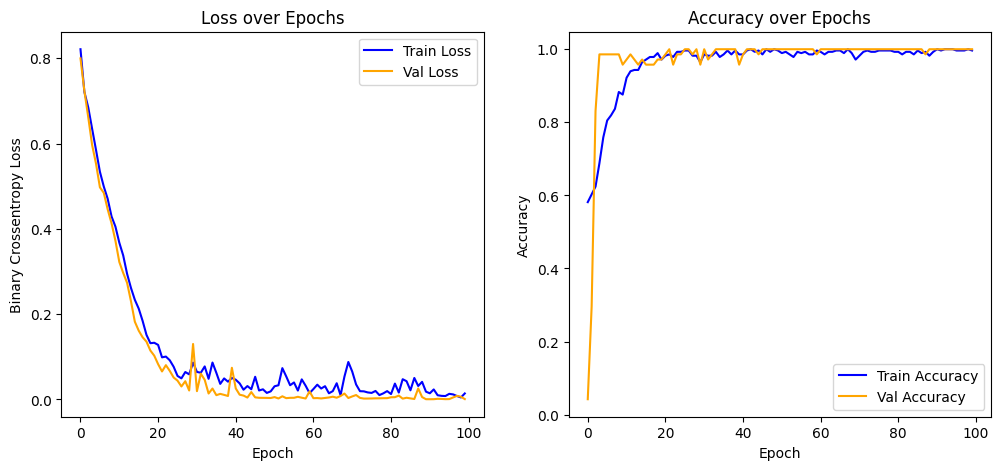

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


##### Metrics

In [ ]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss (MSE): {val_loss:.4f}")
print(f"📈 Validation MAE: {val_mae:.4f}")


📉 Validation Loss (MSE): 0.0093
📈 Validation MAE: 0.0359


## Using Model

#### Load Saved Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("gru_posture_model_snatch_regression.h5")


In [ ]:
data = np.load("regression_dataset_snatch.npz")
X_test = data["X"]
y_test = data["y"]  # optional, if you want to compare

# Predict for all samples
y_pred = model.predict(X_test)

# Example: Compare first prediction with ground truth
print("Predicted:", y_pred[0])
print("Actual   :", y_test[0])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: [ 0.04028483  3.4688342  -0.9196923   1.7480456  -0.21574661]
Actual   : [-40.83803125   4.00943148  84.4181457   97.9865693   -1.17797459]
